# Group Project: Michael Harris, Qihan Guan, Chloe Wang
# January 24th, 2021



In this project, our team was provided with a dataset of the mean per capita (100,000) cancer mortalities, for various counties across the United States. Our task was to determine which of our multivariate X variables were responsible for increases in the cancer mortality rate, and to build an effective linear model with our retained variables to predict cancer mortality rates for counties moving forward. Our team used cross-validation to build a model that was effective out-of-sample.

Next, we set a threshold for cancer mortality rates, and then employed a Logistic Regression to classify counties using our constructed thresholds. To assess the predictive power of our model, our team assessed the accuracy score of our model, the sensitivity, precision, and recall scores using cross-validation. 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Getting Started

In [134]:
# Load data into dataframe
cancer = pd.read_csv("cancer_reg.csv", encoding='latin-1')
cancer.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",2.62,54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",2.34,57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [135]:
#get data dimension
print(cancer.shape)

(3047, 34)


In [136]:
print(cancer.dtypes)

avgAnnCount                float64
avgDeathsPerYear             int64
TARGET_deathRate           float64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite            

In [137]:
#Checking for nulls
cancer.isnull().values.any()

True

In [138]:
#in case nulls need to be handled
for column in cancer.columns.tolist():
    cancer[column].fillna(value=cancer[column].mode()[0], inplace=True)

## Question 1 


In [7]:
#We want to see correlation between quantitative variables only
cancer_quant = cancer.select_dtypes(exclude=['object'])
#Create correlation matrix 
cancer_quant.corr()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
avgAnnCount,1.000000,0.939408,-0.143532,0.073553,0.269145,0.926894,-0.135694,0.082071,-0.024098,-0.124969,-0.122844,0.064788,-0.106108,-0.143327,-0.182054,0.065440,0.284176,-0.311375,0.321021,0.198148,-0.009016,0.132244,0.163485,0.202349,-0.173548,-0.093699,-0.136501,0.031376,0.435071,0.209184,-0.106221,-0.034508
avgDeathsPerYear,0.939408,1.000000,-0.090715,0.062690,0.223207,0.977634,-0.066918,0.063488,-0.024599,-0.148487,-0.144069,0.086161,-0.181029,-0.136794,-0.151418,0.060808,0.259761,-0.295929,0.293210,0.125598,0.069701,0.056183,0.110077,0.160124,-0.131687,-0.027338,-0.187159,0.084607,0.443074,0.215149,-0.160266,-0.074420
TARGET_deathRate,-0.143532,-0.090715,1.000000,0.449432,-0.428615,-0.120073,0.429389,-0.022285,0.004375,-0.021929,0.012048,-0.036905,-0.266820,0.088463,0.261976,-0.092804,-0.287817,0.404589,-0.485477,-0.394139,0.378412,-0.386066,-0.322301,-0.267399,0.404572,0.449358,-0.177400,0.257024,-0.186331,-0.189894,-0.293325,-0.087407
incidenceRate,0.073553,0.062690,0.449432,1.000000,-0.001036,0.026912,0.009046,0.077283,0.018089,-0.014733,-0.009106,-0.118400,-0.119524,-0.170762,0.022644,0.034089,0.046835,0.121725,-0.038177,0.001218,0.099979,0.105174,0.094477,0.149825,0.046109,0.040812,-0.014510,0.113489,-0.008123,-0.208748,-0.152176,-0.118181
medIncome,0.269145,0.223207,-0.428615,-0.001036,1.000000,0.235523,-0.788965,0.044003,-0.013288,-0.091663,-0.153278,0.112065,0.355123,-0.289383,-0.190006,0.100190,0.492810,-0.471348,0.704928,0.666562,-0.453108,0.724175,0.694047,0.747294,-0.754822,-0.719756,0.167225,-0.270232,0.425844,0.083635,0.446083,-0.010195
popEst2015,0.926894,0.977634,-0.120073,0.026912,0.235523,1.000000,-0.065299,0.055722,-0.025219,-0.176608,-0.177932,0.109940,-0.160463,-0.126582,-0.151821,0.061692,0.248375,-0.311849,0.297463,0.140131,0.050768,0.052677,0.118713,0.158650,-0.160066,-0.041469,-0.190095,0.073044,0.464168,0.241468,-0.127979,-0.057740
povertyPercent,-0.135694,-0.066918,0.429389,0.009046,-0.788965,-0.065299,1.000000,-0.055652,-0.029280,-0.214001,-0.148164,0.074308,-0.642857,0.288106,0.094211,-0.077126,-0.387122,0.194361,-0.531600,-0.709363,0.655148,-0.822534,-0.671143,-0.683100,0.651162,0.798642,-0.509433,0.511530,-0.157289,0.047096,-0.604953,-0.012283
studyPerCap,0.082071,0.063488,-0.022285,0.077283,0.044003,0.055722,-0.055652,1.000000,-0.026030,-0.036647,-0.030577,-0.004071,-0.038143,-0.090387,-0.057035,0.037497,0.063819,-0.085128,0.108594,0.089449,-0.031957,0.092545,0.064772,0.100063,-0.051497,-0.055512,0.023291,-0.019761,0.062543,-0.015247,-0.051736,0.010676
MedianAge,-0.024098,-0.024599,0.004375,0.018089,-0.013288,-0.025219,-0.029280,-0.026030,1.000000,0.129119,0.124678,-0.031944,0.046372,0.006178,0.050574,-0.009066,-0.016909,0.036587,-0.020352,-0.025628,0.018590,0.004665,-0.019648,-0.036926,0.049060,-0.003298,0.035009,-0.017173,-0.038424,-0.030277,0.014504,-0.008276
MedianAgeMale,-0.124969,-0.148487,-0.021929,-0.014733,-0.091663,-0.176608,-0.214001,-0.036647,0.129119,1.000000,0.933696,-0.343189,0.449986,0.100486,0.241310,-0.130490,-0.034135,0.318277,-0.131599,-0.156424,-0.142737,0.082232,-0.144221,-0.208664,0.398967,0.002479,0.398044,-0.242748,-0.238322,-0.266655,0.222278,-0.104105


Next, run correlation matrix with all variables.

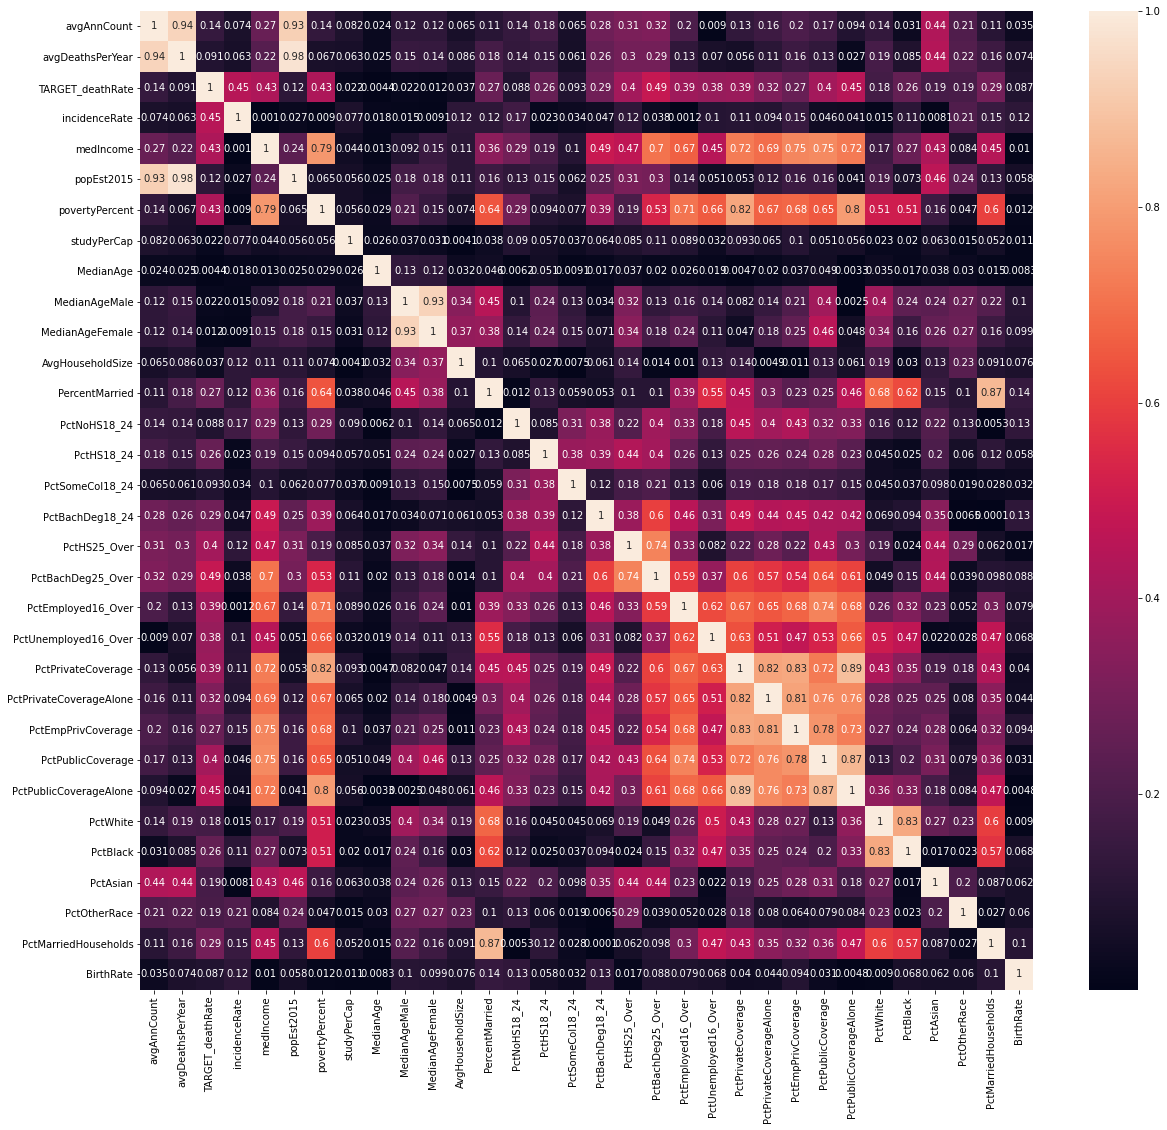

In [10]:
# Correlation matrix w/ Absolute Values 
plt.subplots(figsize=(20, 18))
sns.heatmap(cancer_quant.corr().abs(),annot=True)
plt.show()

In [11]:
# Unstack Data
cor_pairs = cancer_quant.corr().unstack()

In [12]:
# Define correlation cutoff point at 0.7 as "Strong Correlation." Then, output pairs with high correlation. 
# This provides strong correlations for all variables in the dataset.
strong_pairs = cor_pairs[((cor_pairs) > 0.7) & ((cor_pairs) < 1.0)]
pd.options.display.max_rows = 200
strong_pairs

avgAnnCount              avgDeathsPerYear           0.939408
                         popEst2015                 0.926894
avgDeathsPerYear         avgAnnCount                0.939408
                         popEst2015                 0.977634
medIncome                PctBachDeg25_Over          0.704928
                         PctPrivateCoverage         0.724175
                         PctEmpPrivCoverage         0.747294
popEst2015               avgAnnCount                0.926894
                         avgDeathsPerYear           0.977634
povertyPercent           PctPublicCoverageAlone     0.798642
MedianAgeMale            MedianAgeFemale            0.933696
MedianAgeFemale          MedianAgeMale              0.933696
PercentMarried           PctMarriedHouseholds       0.870261
PctBachDeg25_Over        medIncome                  0.704928
PctPrivateCoverage       medIncome                  0.724175
                         PctPrivateCoverageAlone    0.819430
                        

In [8]:
# Analyze Correlation for Target Varible. 
cor_target = cancer.corr().abs()['TARGET_deathRate']

# Sort by strongest correlations. Strongest correlations are with Percent Bachelor's Degree Over 25, Incidence Rate, Poverty
# Percentage, Medium Income, & PctPublicCoverageAlone.
sorted_cor_target = cor_target.sort_values(kind = 'Quicksort', ascending=False)
sorted_cor_target


TARGET_deathRate           1.000000
PctBachDeg25_Over          0.485477
incidenceRate              0.449432
PctPublicCoverageAlone     0.449358
povertyPercent             0.429389
medIncome                  0.428615
PctHS25_Over               0.404589
PctPublicCoverage          0.404572
PctEmployed16_Over         0.394139
PctPrivateCoverage         0.386066
PctUnemployed16_Over       0.378412
PctPrivateCoverageAlone    0.322301
PctMarriedHouseholds       0.293325
PctBachDeg18_24            0.287817
PctEmpPrivCoverage         0.267399
PercentMarried             0.266820
PctHS18_24                 0.261976
PctBlack                   0.257024
PctOtherRace               0.189894
PctAsian                   0.186331
PctWhite                   0.177400
avgAnnCount                0.143532
popEst2015                 0.120073
PctSomeCol18_24            0.092804
avgDeathsPerYear           0.090715
PctNoHS18_24               0.088463
BirthRate                  0.087407
AvgHouseholdSize           0

Build visualizations and plots to see how the TARGET_deathRatevariable varies with some of the other variables

In [14]:
len(sorted_cor_target[(sorted_cor_target)>0.3])

12

In [15]:
cols = sorted_cor_target[(sorted_cor_target)>0.3].index.tolist()
cols

['TARGET_deathRate',
 'PctBachDeg25_Over',
 'incidenceRate',
 'PctPublicCoverageAlone',
 'povertyPercent',
 'medIncome',
 'PctHS25_Over',
 'PctPublicCoverage',
 'PctEmployed16_Over',
 'PctPrivateCoverage',
 'PctUnemployed16_Over',
 'PctPrivateCoverageAlone']

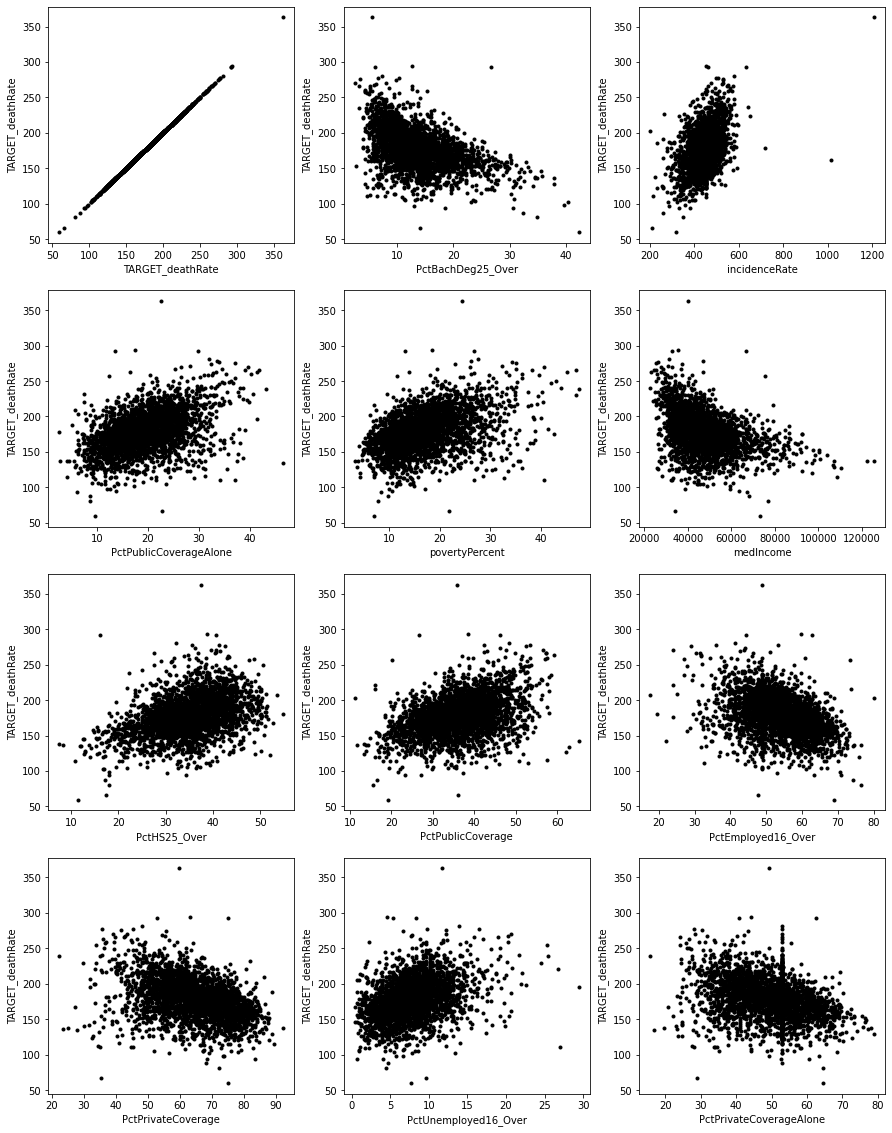

In [91]:
fig, ax = plt.subplots(4, 3, figsize = (15,20))
for i in range(4):
   for j in range(3):
     ax[i,j].plot(cancer[cols[i*3+j]], cancer.TARGET_deathRate, '.', color='black')
     ax[i,j].set_xlabel(cols[i*3+j])
     ax[i,j].set_ylabel('TARGET_deathRate')

For Medium income, as income increases, target deathrate decreases.\
For Poverty Percent, as poverty percent increases, target deathrate increases.\
For PctPublicCoverageAlone, as PctPublicCoverageAlone increases, target deathrate increases.\
For Incidence Rate, as Incidence Rate increases, target deathrate increases.\
For Percent Bachelor's Degree Over 25 , as Percent Bachelor's Degree Over 25 increases, target deathrate decreases. This could represent more educated & wealthy areas suffer less than poorer areas.\
For PctHS25_Over, as PctHS25_Over increases, target deathrate increases.

## Question 2

Check distribution and skewness on quantitative variables. Transform data if necessary. 

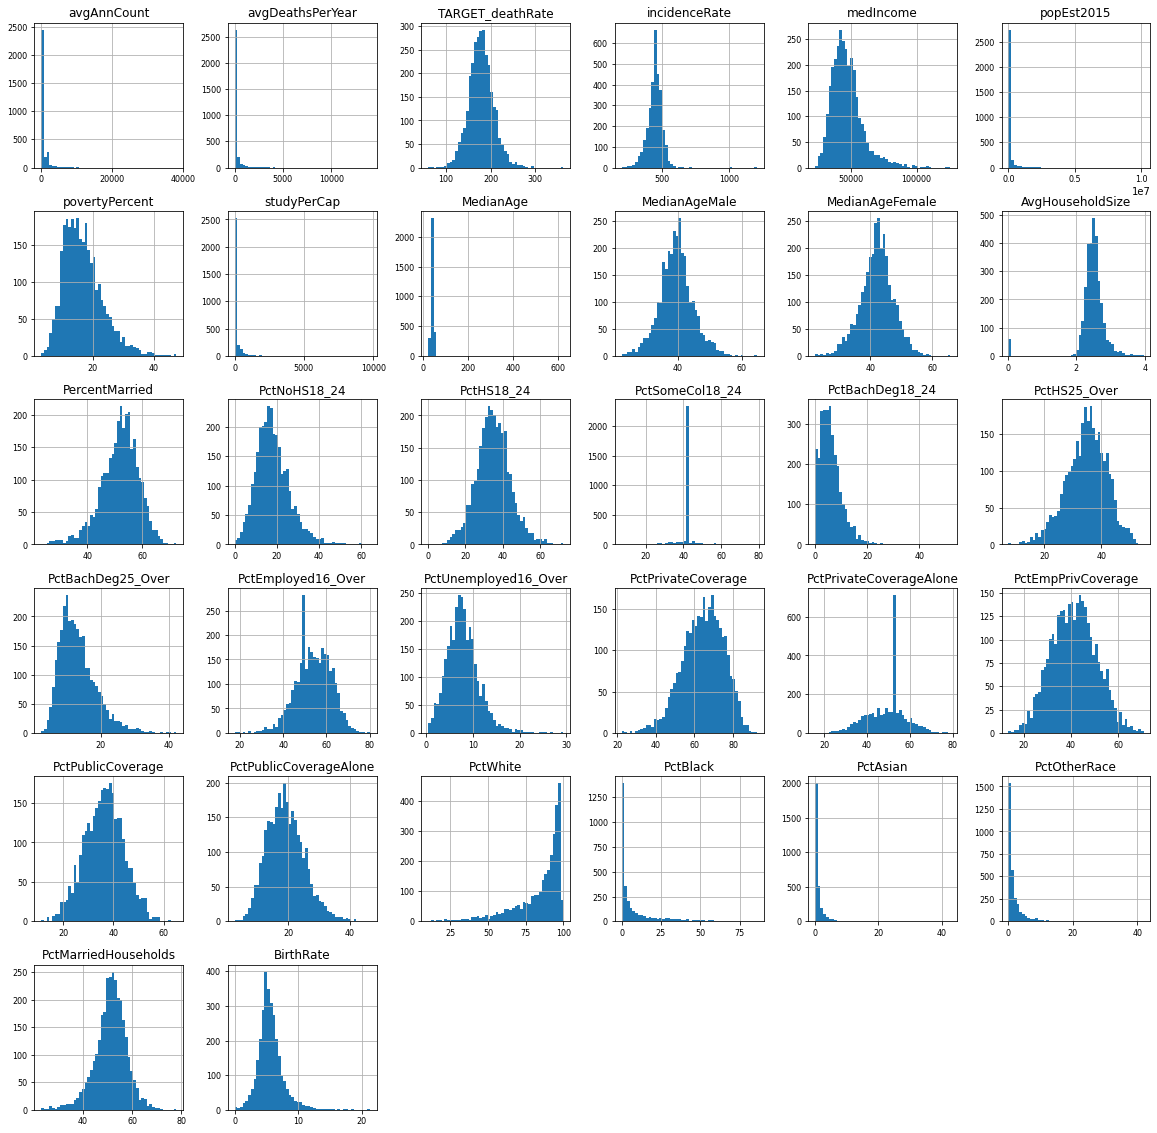

In [61]:
cancer_quant = cancer.copy().select_dtypes(exclude=['object'])
cancer_quant.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

Judging from the distribution plot, we found that variables 'avgAnnCount', 'avgDeathsPerYear', 'popEst2015', 'studyPerCap', 'MedianAge', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace' exhibit high skewness. We will try to log-transform them and see if that corrects the skewness.

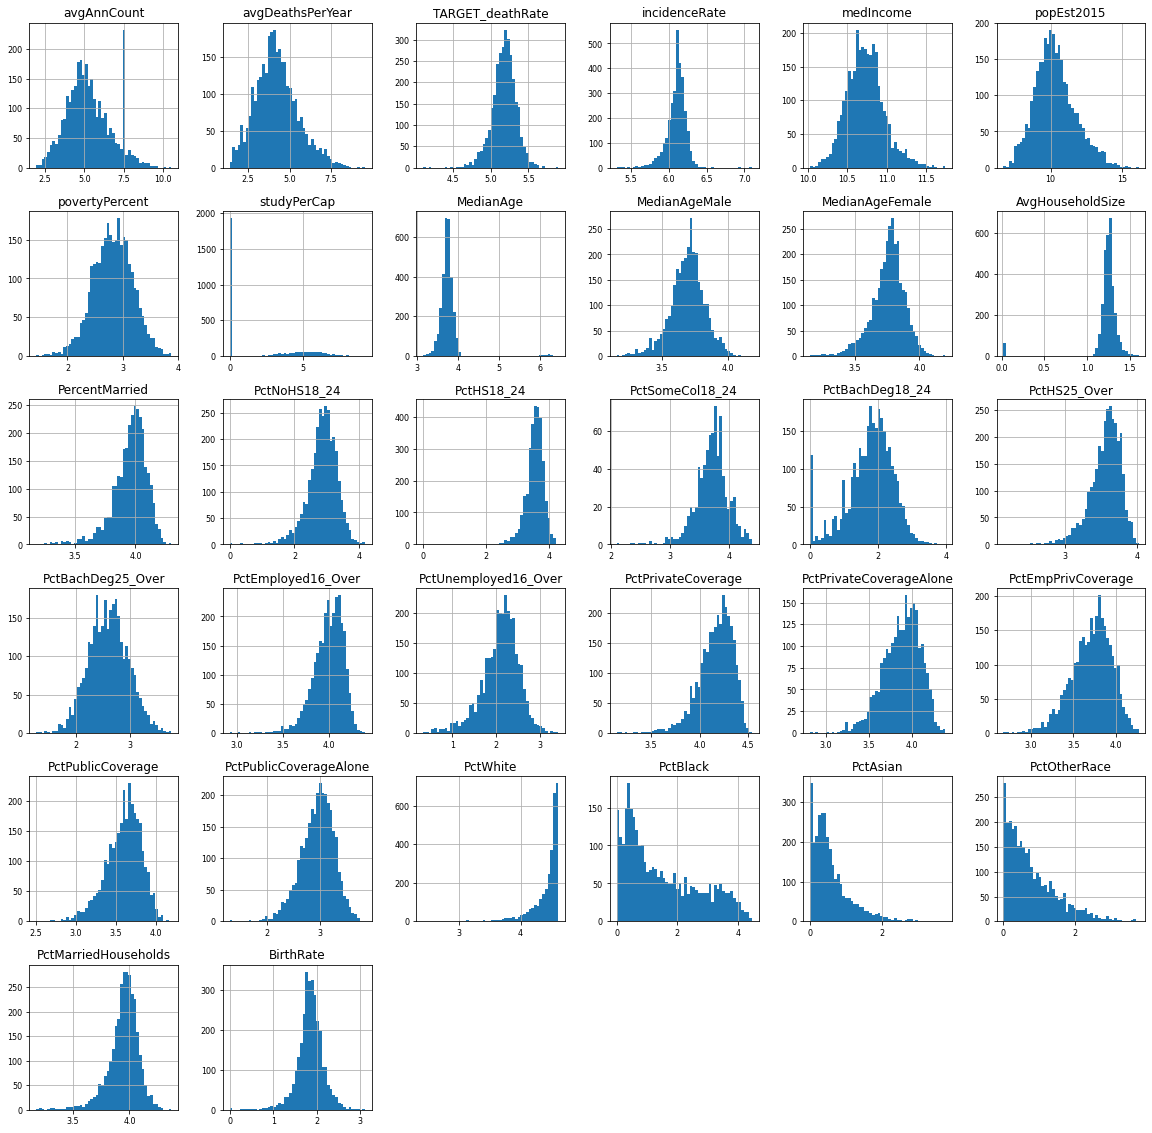

In [186]:
cancer_quant_log = cancer.copy().select_dtypes(exclude=['object'])
for column in cancer_quant_log.columns.tolist():
    cancer_quant_log[column]=np.log1p(cancer_quant_log[column])
cancer_quant_log.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

Judging from the distribution plot after transformation, we found that the skewness for variables 'avgAnnCount', 'avgDeathsPerYear', 'popEst2015', 'studyPerCap', and 'MedianAge' are significantly corrected. We will log-transform these 5 variables. 

In [85]:
processed_cancer = cancer.copy()
processed_cancer['avgAnnCount'] = np.log1p(processed_cancer['avgAnnCount'])
processed_cancer['avgDeathsPerYear'] = np.log1p(processed_cancer['avgDeathsPerYear'])
processed_cancer['popEst2015'] = np.log1p(processed_cancer['popEst2015'])
processed_cancer['studyPerCap'] = np.log1p(processed_cancer['studyPerCap'])
processed_cancer['MedianAge'] = np.log1p(processed_cancer['MedianAge'])

We will also need to one-hot encode the object-typed variables


In [86]:
processed_cancer1 = pd.get_dummies(processed_cancer)

In [55]:
processed_cancer1.shape

(3047, 3089)

In [12]:
processed_cancer1.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,"binnedInc_(34218.1, 37413.8]","binnedInc_(37413.8, 40362.7]","binnedInc_(40362.7, 42724.4]","binnedInc_(42724.4, 45201]","binnedInc_(45201, 48021.6]","binnedInc_(48021.6, 51046.4]","binnedInc_(51046.4, 54545.6]","binnedInc_(54545.6, 61494.5]",...,"Geography_Worcester County, Maryland","Geography_Worcester County, Massachusetts","Geography_Worth County, Georgia","Geography_Worth County, Iowa","Geography_Worth County, Missouri","Geography_Wright County, Iowa","Geography_Wright County, Minnesota","Geography_Wright County, Missouri","Geography_Wyandot County, Ohio","Geography_Wyandotte County, Kansas","Geography_Wyoming County, New York","Geography_Wyoming County, Pennsylvania","Geography_Wyoming County, West Virginia","Geography_Wythe County, Virginia","Geography_Yadkin County, North Carolina","Geography_Yakima County, Washington","Geography_Yalobusha County, Mississippi","Geography_Yamhill County, Oregon","Geography_Yancey County, North Carolina","Geography_Yankton County, South Dakota","Geography_Yates County, New York","Geography_Yavapai County, Arizona","Geography_Yazoo County, Mississippi","Geography_Yell County, Arkansas","Geography_Yellow Medicine County, Minnesota","Geography_Yellowstone County, Montana","Geography_Yoakum County, Texas","Geography_Yolo County, California","Geography_York County, Maine","Geography_York County, Nebraska","Geography_York County, Pennsylvania","Geography_York County, South Carolina","Geography_York County, Virginia","Geography_Young County, Texas","Geography_Yuba County, California","Geography_Yukon-Koyukuk Census Area, Alaska","Geography_Yuma County, Arizona","Geography_Yuma County, Colorado","Geography_Zapata County, Texas","Geography_Zavala County, Texas"
0,7.242798,6.152733,164.9,489.8,61898,12.468944,11.2,6.216103,3.696351,36.9,41.7,2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,53.0,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.159055,4.262680,161.3,411.6,48127,10.675215,18.6,3.182678,3.526361,32.2,33.7,2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.634729,3.931826,174.7,349.7,49348,9.953563,14.6,3.882804,3.828641,44.0,45.8,2.62,54.2,24.0,36.6,43.0,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.059123,5.313206,194.8,430.4,44243,11.236948,17.1,5.839587,3.779634,42.2,43.4,2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.060443,3.295837,144.4,350.1,49955,9.242033,12.5,0.000000,3.897924,47.8,48.9,2.34,57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now regress TARGET_deathRate on all other variables with the preprocessed data

In [87]:
# Linear Regression with ALL variables.

#70% records being sent into training set 
pts = np.random.rand(len(processed_cancer1)) < 0.7

cancer_train = processed_cancer1[pts]
cancer_test = processed_cancer1[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
Y_train = cancer_train['TARGET_deathRate']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
Y_test = cancer_test['TARGET_deathRate']

#fitting linear regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
r2 = linreg.score(X_test, Y_test)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % ( 1 - (1-r2)*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1) ))

coefficient of determination: 0.73
adjusted R-square: 1.11


The adjusted R-square went above 1, which is a big problem. We now diagnosis this issue.

In [79]:
print(len(Y_test))
print(X_test.shape[1])
print((len(Y_test)-X_test.shape[1]-1))

914
3088
-2175


We have way too many predictors, even more than the number of test data. We therefore got a negative subtraction term for the adjusted R-square formula. That's why the adjusted R-square went above 1. We will consider dropping 'Geography' as it needs too many dummy variables.

## Question 3a

There are 3047 unique 'Geography' values. This is the same as the total number of observations. Plus, we already have other variables that tell the county residents' characteristics. There is no point to create thousands of dummy variables. We will drop the 'Geography' variable. 

'binnedInc' can be treated as income bracket. Therefore, it's ordinal data. We can use Spearman's Rank correlation to test it's correlation with 'TARGET_deathRate'

In [51]:
#Check number of unique binned income 
cancer['binnedInc'].nunique()

10

In [52]:
cancer_melt = pd.melt(cancer.copy(), id_vars=['binnedInc'], value_vars=['TARGET_deathRate'])

In [53]:
cancer_melt

,binnedInc,variable,value
0,"(61494.5, 125635]",TARGET_deathRate,164.9
1,"(48021.6, 51046.4]",TARGET_deathRate,161.3
2,"(48021.6, 51046.4]",TARGET_deathRate,174.7
3,"(42724.4, 45201]",TARGET_deathRate,194.8
4,"(48021.6, 51046.4]",TARGET_deathRate,144.4
...,...,...,...
3042,"(45201, 48021.6]",TARGET_deathRate,149.6
3043,"(48021.6, 51046.4]",TARGET_deathRate,150.1
3044,"(51046.4, 54545.6]",TARGET_deathRate,153.9
3045,"(48021.6, 51046.4]",TARGET_deathRate,175.0


In [57]:
from scipy.stats import spearmanr
coef, p = spearmanr(cancer_melt['binnedInc'], cancer_melt['value'])
print(coef)
print(p)

-0.19412569137848443
2.9453097355129375e-27


p value is not significant, we will drop the 'binnedInc' column

In [58]:
cancer['Geography'].nunique()

3047

In [95]:
processed_cancer2= processed_cancer.copy().drop(columns=['binnedInc','Geography'])
processed_cancer2.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,7.242798,6.152733,164.9,489.8,61898,12.468944,11.2,6.216103,3.696351,36.9,41.7,2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,53.0,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,5.159055,4.262680,161.3,411.6,48127,10.675215,18.6,3.182678,3.526361,32.2,33.7,2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,4.634729,3.931826,174.7,349.7,49348,9.953563,14.6,3.882804,3.828641,44.0,45.8,2.62,54.2,24.0,36.6,43.0,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,6.059123,5.313206,194.8,430.4,44243,11.236948,17.1,5.839587,3.779634,42.2,43.4,2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,4.060443,3.295837,144.4,350.1,49955,9.242033,12.5,0.000000,3.897924,47.8,48.9,2.34,57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


Now we see how model performs after dropping these two variables.

In [89]:
#pts = np.random.rand(len(processed_cancer2)) < 0.7
#use the same train/test split for accurate comparision
cancer_train = processed_cancer2[pts]
cancer_test = processed_cancer2[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
Y_train = cancer_train['TARGET_deathRate']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
Y_test = cancer_test['TARGET_deathRate']

#fitting linear regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

#R^2
r2 = linreg.score(X_test, Y_test)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % (1 - (1-r2)*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1)))

coefficient of determination: 0.72
adjusted R-square: 0.71


The R-square does not improve. However, the adjusted R-square is normal now. 

Next, we will consider multicollinearity. If one pair of variables exhibit high correaltion, we will drop one of them. 

In [99]:
cor_matrix = cancer_quant.corr().abs()
features_multicol = set()
feature_list = [x for x in cor_matrix]
n = len(feature_list)
for i in range(n):
    for j in range(i+1, n):
        f1 = feature_list[i]
        f2 = feature_list[j]
        if abs(cor_matrix[f1][f2]) > 0.8: features_multicol.add(f1)
features_multicol

{'MedianAgeMale',
 'PctPrivateCoverage',
 'PctPrivateCoverageAlone',
 'PctPublicCoverage',
 'PctWhite',
 'PercentMarried',
 'avgAnnCount',
 'avgDeathsPerYear',
 'povertyPercent'}

In [100]:
processed_cancer3 = processed_cancer2.copy()

In [101]:
processed_cancer3=processed_cancer3.drop(features_multicol, axis =1)

In [102]:
processed_cancer3.shape

(3047, 23)

In [94]:
# Linear Regression with dropped multicollinearity variables.

#70% records being sent into training set 
#pts = np.random.rand(len(processed_cancer3)) < 0.7

cancer_train = processed_cancer3[pts]
cancer_test = processed_cancer3[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
Y_train = cancer_train['TARGET_deathRate']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
Y_test = cancer_test['TARGET_deathRate']

#fitting linear regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
r2 = linreg.score(X_test, Y_test)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % (1 - (1-r2)*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1)))

coefficient of determination: 0.49
adjusted R-square: 0.48


This filtering by multicollinearity technique does not work well for our case. Both R-squared value and adjusted R-square value significantly dropped. We will consider to use RFE(recursive feature elimination) to select the best set of features.

In [98]:
from sklearn.feature_selection import RFECV
#recap that processed_cancer2 is the processed data with 'Geography' and 'binnedInc' dropped. 
#pts = np.random.rand(len(processed_cancer2)) < 0.7
cancer_train = processed_cancer2[pts]
cancer_test = processed_cancer2[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
Y_train = cancer_train['TARGET_deathRate']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
Y_test = cancer_test['TARGET_deathRate']

linreg = LinearRegression()
rfecv = RFECV(estimator=linreg)
rfecv.fit(X_train, Y_train)
print('Best number of features selected: %d' % rfecv.n_features_)

r2 = rfecv.score(X_test, Y_test)
print("coefficient of determination: %.2f" % r2)
print("adjusted R-square: %.2f" % (1 - (1-r2)*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1)))

Best number of features selected: 31
coefficient of determination: 0.72
adjusted R-square: 0.71


The RFE indicates the best number of features selected is 31. This means that no additional features were elinimated. R-squared value and adjusted R-square value did not improve. We can conclude that dropping only 'Geography' and 'binnedInc' and keeping the rest processsed variables yield the model with the highest R-square value. 

## Question 3b

FDR will not be useful for this analysis. Controlling FDR means to control the percentage of false positives. In our case, false positives are variables that do not significantly affect cancer mortalities are called significant. Controlling false positives poses a risk of increasing the number of false negatives. We may ignore some variables that actually impact cancer mortalities. We should worry more about false negatives here. In addition, FDR control assumes rough independence between tests. We have many variables that are highly correlated with another. We cannot guarantee independence between tests for our case. 

## Question 3c

In question 2, we identified 12 variables that have a correlation coefficient of 0.3 and higher with 'TARGET_deathRate'. We are interested in their interactions' impact on 'TARGET_deathRate'. 

In [131]:
cor_target = cancer.corr().abs()['TARGET_deathRate']

# Sort by strongest correlations. 
sorted_cor_target = cor_target.sort_values(kind = 'Quicksort', ascending=False)
print(sorted_cor_target[(sorted_cor_target)>0.3])
cols = sorted_cor_target[(sorted_cor_target)>0.3].index.tolist()


TARGET_deathRate           1.000000
PctBachDeg25_Over          0.485477
incidenceRate              0.449432
PctPublicCoverageAlone     0.449358
povertyPercent             0.429389
medIncome                  0.428615
PctHS25_Over               0.404589
PctPublicCoverage          0.404572
PctEmployed16_Over         0.394139
PctPrivateCoverage         0.386066
PctUnemployed16_Over       0.378412
PctPrivateCoverageAlone    0.322301
Name: TARGET_deathRate, dtype: float64


In [132]:
#create mini_cancer of columns of interest
mini_cancer = cancer[cols]
poly = preprocessing.PolynomialFeatures(2, interaction_only=True, include_bias=False)
mini_cancer_nparray = poly.fit_transform(mini_cancer)

target_feature_names = ['_x_'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(mini_cancer.columns,p) for p in poly.powers_]]
mini_cancer_2d = pd.DataFrame(mini_cancer_nparray, columns = target_feature_names)

mini_cancer_2d.head()

,TARGET_deathRate^1,PctBachDeg25_Over^1,incidenceRate^1,PctPublicCoverageAlone^1,povertyPercent^1,medIncome^1,PctHS25_Over^1,PctPublicCoverage^1,PctEmployed16_Over^1,PctPrivateCoverage^1,PctUnemployed16_Over^1,PctPrivateCoverageAlone^1,TARGET_deathRate^1_x_PctBachDeg25_Over^1,TARGET_deathRate^1_x_incidenceRate^1,TARGET_deathRate^1_x_PctPublicCoverageAlone^1,TARGET_deathRate^1_x_povertyPercent^1,TARGET_deathRate^1_x_medIncome^1,TARGET_deathRate^1_x_PctHS25_Over^1,TARGET_deathRate^1_x_PctPublicCoverage^1,TARGET_deathRate^1_x_PctEmployed16_Over^1,TARGET_deathRate^1_x_PctPrivateCoverage^1,TARGET_deathRate^1_x_PctUnemployed16_Over^1,TARGET_deathRate^1_x_PctPrivateCoverageAlone^1,PctBachDeg25_Over^1_x_incidenceRate^1,PctBachDeg25_Over^1_x_PctPublicCoverageAlone^1,PctBachDeg25_Over^1_x_povertyPercent^1,PctBachDeg25_Over^1_x_medIncome^1,PctBachDeg25_Over^1_x_PctHS25_Over^1,PctBachDeg25_Over^1_x_PctPublicCoverage^1,PctBachDeg25_Over^1_x_PctEmployed16_Over^1,PctBachDeg25_Over^1_x_PctPrivateCoverage^1,PctBachDeg25_Over^1_x_PctUnemployed16_Over^1,PctBachDeg25_Over^1_x_PctPrivateCoverageAlone^1,incidenceRate^1_x_PctPublicCoverageAlone^1,incidenceRate^1_x_povertyPercent^1,incidenceRate^1_x_medIncome^1,incidenceRate^1_x_PctHS25_Over^1,incidenceRate^1_x_PctPublicCoverage^1,incidenceRate^1_x_PctEmployed16_Over^1,incidenceRate^1_x_PctPrivateCoverage^1,incidenceRate^1_x_PctUnemployed16_Over^1,incidenceRate^1_x_PctPrivateCoverageAlone^1,PctPublicCoverageAlone^1_x_povertyPercent^1,PctPublicCoverageAlone^1_x_medIncome^1,PctPublicCoverageAlone^1_x_PctHS25_Over^1,PctPublicCoverageAlone^1_x_PctPublicCoverage^1,PctPublicCoverageAlone^1_x_PctEmployed16_Over^1,PctPublicCoverageAlone^1_x_PctPrivateCoverage^1,PctPublicCoverageAlone^1_x_PctUnemployed16_Over^1,PctPublicCoverageAlone^1_x_PctPrivateCoverageAlone^1,povertyPercent^1_x_medIncome^1,povertyPercent^1_x_PctHS25_Over^1,povertyPercent^1_x_PctPublicCoverage^1,povertyPercent^1_x_PctEmployed16_Over^1,povertyPercent^1_x_PctPrivateCoverage^1,povertyPercent^1_x_PctUnemployed16_Over^1,povertyPercent^1_x_PctPrivateCoverageAlone^1,medIncome^1_x_PctHS25_Over^1,medIncome^1_x_PctPublicCoverage^1,medIncome^1_x_PctEmployed16_Over^1,medIncome^1_x_PctPrivateCoverage^1,medIncome^1_x_PctUnemployed16_Over^1,medIncome^1_x_PctPrivateCoverageAlone^1,PctHS25_Over^1_x_PctPublicCoverage^1,PctHS25_Over^1_x_PctEmployed16_Over^1,PctHS25_Over^1_x_PctPrivateCoverage^1,PctHS25_Over^1_x_PctUnemployed16_Over^1,PctHS25_Over^1_x_PctPrivateCoverageAlone^1,PctPublicCoverage^1_x_PctEmployed16_Over^1,PctPublicCoverage^1_x_PctPrivateCoverage^1,PctPublicCoverage^1_x_PctUnemployed16_Over^1,PctPublicCoverage^1_x_PctPrivateCoverageAlone^1,PctEmployed16_Over^1_x_PctPrivateCoverage^1,PctEmployed16_Over^1_x_PctUnemployed16_Over^1,PctEmployed16_Over^1_x_PctPrivateCoverageAlone^1,PctPrivateCoverage^1_x_PctUnemployed16_Over^1,PctPrivateCoverage^1_x_PctPrivateCoverageAlone^1,PctUnemployed16_Over^1_x_PctPrivateCoverageAlone^1
0,164.9,19.6,489.8,14.0,11.2,61898.0,23.2,32.9,51.9,75.1,8.0,53.0,3232.04,80768.02,2308.60,1846.88,10206980.2,3825.68,5425.21,8558.31,12383.99,1319.20,8739.70,9600.08,274.40,219.52,1213200.8,454.72,644.84,1017.24,1471.96,156.80,1038.80,6857.20,5485.76,30317640.4,11363.36,16114.42,25420.62,36783.98,3918.40,25959.40,156.80,866572.0,324.80,460.60,726.60,1051.40,112.00,742.00,693257.6,259.84,368.48,581.28,841.12,89.60,593.60,1436033.6,2036444.2,3212506.2,4648539.8,495184.0,3280594.0,763.28,1204.08,1742.32,185.60,1229.60,1707.51,2470.79,263.20,1743.70,3897.69,415.20,2750.70,600.80,3980.30,424.00
1,161.3,22.7,411.6,15.3,18.6,48127.0,26.0,31.1,55.9,70.2,7.8,53.8,3661.51,66391.08,2467.89,3000.18,7762885.1,4193.80,5016.43,9016.67,11323.26,1258.14,8677.94,9343.32,347.31,422.22,1092482.9,590.20,705.97,1268.93,1593.54,177.06,1221.26,6297.48,7655.76,19809073.2,10701.60,12800.76,23008.44,28894.32,3210.48,22144.08,284.58,736343.1,397.80,475.83,855.27,1074.06,119.34,823.14,895162.2,483.60,578.46,1039.74,1305.72,145.08,1000.68,1251302.0,1496749.7,2

In [125]:
X=mini_cancer_2d.drop('TARGET_deathRate^1', 1)
y=mini_cancer_2d['TARGET_deathRate^1']

In [126]:
from statsmodels.regression import linear_model
interaction_ols = linear_model.OLS(y, X).fit()
interaction_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     TARGET_deathRate^1   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.524e+06
Date:                Sun, 24 Jan 2021   Prob (F-statistic):                        0.00
Time:                        21:13:59   Log-Likelihood:                         -3266.0
No. Observations:                3047   AIC:                                      6686.
Df Residuals:                    2970   BIC:                                      7150.
Df Model:                          77                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
PctBachDeg25_Over^1                                     -0.4889      0.134     -3.651      0.000      -0.751      -0.226
incidenceRate^1                                          0.2249      0.008     28.322      0.000       0.209       0.240
PctPublicCoverageAlone^1                                 0.5952      0.155      3.849      0.000       0.292       0.898
povertyPercent^1                                         0.6367      0.079      8.040      0.000       0.481       0.792
medIncome^1                                              0.0001   5.22e-05      2.676      0.007    3.73e-05       0.000
PctHS25_Over^1                                           1.1114      0.086     12.936      0.000       0.943       1.280
PctPublicCoverage^1                                      0.0219      0.097      0.225      0.822      -0.168       0.212
PctEmployed16_Over^1                                    -0.0706      0.050     -1.411      0.158      -0.169       0.027
PctPrivateCoverage^1                                     0.1098      0.078      1.411      0.158      -0.043       0.262
PctUnemployed16_Over^1                                   0.8924      0.154      5.807      0.000       0.591       1.194
PctPrivateCoverageAlone^1                                0.1299      0.072      1.802      0.072      -0.011       0.271
TARGET_deathRate^1_x_PctBachDeg25_Over^1                 0.0009      0.000      4.092      0.000       0.000       0.001
TARGET_deathRate^1_x_incidenceRate^1                  8.835e-06   6.04e-06      1.464      0.143      -3e-06    2.07e-05
TARGET_deathRate^1_x_PctPublicCoverageAlone^1         -4.68e-06      0.000     -0.014      0.989      -0.001       0.001
TARGET_deathRate^1_x_povertyPercent^1                    0.0076      0.000     39.428      0.000       0.007       0.008
TARGET_deathRate^1_x_medIncome^1                      2.999e-06   1.18e-07     25.357      0.000    2.77e-06    3.23e-06
TARGET_deathRate^1_x_PctHS25_Over^1                      0.0022      0.000     15.799      0.000       0.002       0.002
TARGET_deathRate^1_x_PctPublicCoverage^1                 0.0053      0.000     24.589      0.000       0.005       0.006
TARGET_deathRate^1_x_PctEmployed16_Over^1                0.0040      0.000     35.974      0.000       0.004       0.004
TARGET_deathRate^1_x_PctPrivateCoverage^1                0.0032      0.000     20.003      0.000       0.003       0.004
TARGET_deathRate^1_x_PctUnemployed16_Over^1              0.0010      0.000      4.216      0.000       0.001       0.002
TARGET_deathRate^1_x_PctPrivateCoverageAlone^1           0.0003      0.000      

We regress 'TARGET_deathRate' on the variables in mini_cancer and their interaction terms. We then looked at the p values for the interaction terms and the coefficients. 

## Question 3d

In [203]:
cancer['TARGET_deathRate'].median()

178.1

In [207]:
#use our model from 3a, which dropped 'binnedInc', and 'Geography'
processed_cancer_cls = processed_cancer2.copy()
processed_cancer_cls['TARGET_deathRate'] = np.where(processed_cancer_cls['TARGET_deathRate']<=178.1, 0, 1)
pts = np.random.rand(len(processed_cancer_cls)) < 0.7

cancer_train = processed_cancer_cls[pts]
cancer_test = processed_cancer_cls[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
Y_train = cancer_train['TARGET_deathRate']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
Y_test = cancer_test['TARGET_deathRate']

logreg3 = LogisticRegression()
logreg3.fit(X_train, Y_train)

#generating confusion matrix
Y_pred = logreg3.predict(X_test)
confusionMatrix = confusion_matrix(Y_test, Y_pred)
print(confusionMatrix)

print ('Accuracy :', metrics.accuracy_score(Y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(Y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(Y_test, Y_pred) )
print ('Precision:', metrics.precision_score(Y_test, Y_pred) )

[[342 106]
 [109 341]]
Accuracy : 0.7605790645879733
F1 score : 0.7603121516164996
Recall   : 0.7577777777777778
Precision: 0.7628635346756152


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


If we set the median value to be the cutoff for 'TARGET_deathRate', the logistic regression model yields an accuracy of 0.76 with the features we selected. This shows a slight improvement over the linear regression model. We can also use techniques such as DecisionTreeRegression() to test if non-linear regression gives a better fit. 

## Question 4 Logistic Regression

In [185]:
from sklearn import metrics

mini_cancer = cancer[cancer.columns[:34]]

mini_cancer['avgDeathsPerYear'] = np.where(mini_cancer['avgDeathsPerYear']<=1000, 0, 1)

#70% records being sent into training set 
pts = np.random.rand(len(mini_cancer)) < 0.7

cancer_train = mini_cancer[pts]
cancer_test = mini_cancer[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
X_train = X_train.drop('avgDeathsPerYear', 1)
X_train = X_train.drop('binnedInc', 1)
X_train = X_train.drop('Geography', 1)
Y_train = cancer_train['avgDeathsPerYear']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
X_test = X_test.drop('avgDeathsPerYear', 1)
X_test = X_test.drop('binnedInc', 1)
X_test = X_test.drop('Geography', 1)
Y_test = cancer_test['avgDeathsPerYear']

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

#generating confusion matrix
Y_pred = logreg.predict(X_test)
confusionMatrix = confusion_matrix(Y_test, Y_pred)
print(confusionMatrix)
#diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
#diagram.plot()

[[893   4]
 [  3  25]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [186]:
print ('Accuracy :', metrics.accuracy_score(Y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(Y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(Y_test, Y_pred) )
print ('Precision:', metrics.precision_score(Y_test, Y_pred) )

Accuracy : 0.9924324324324324
F1 score : 0.8771929824561403
Recall   : 0.8928571428571429
Precision: 0.8620689655172413


RFE to optimize feature selection

In [201]:
mini_cancer = cancer[cancer.columns[:34]]

mini_cancer['avgDeathsPerYear'] = np.where(mini_cancer['avgDeathsPerYear']<=1000, 0, 1)

#70% records being sent into training set 
#pts = np.random.rand(len(mini_cancer)) < 0.7

cancer_train = mini_cancer[pts]
cancer_test = mini_cancer[~pts]

X_train = cancer_train.copy()
X_train = X_train.drop('TARGET_deathRate', 1)
X_train = X_train.drop('avgDeathsPerYear', 1)
X_train = X_train.drop('binnedInc', 1)
X_train = X_train.drop('Geography', 1)
Y_train = cancer_train['avgDeathsPerYear']

X_test = cancer_test.copy()
X_test = X_test.drop('TARGET_deathRate', 1)
X_test = X_test.drop('avgDeathsPerYear', 1)
X_test = X_test.drop('binnedInc', 1)
X_test = X_test.drop('Geography', 1)
Y_test = cancer_test['avgDeathsPerYear']

rfe = RFE(LogisticRegression(), 29)
rfe = rfe.fit(X_train, Y_train)
Y_pred1 = rfe.predict(X_test)




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [202]:
print ('Accuracy :', metrics.accuracy_score(Y_test, Y_pred1) )
print ('F1 score :', metrics.f1_score(Y_test, Y_pred1) )
print ('Recall   :', metrics.recall_score(Y_test, Y_pred1) )
print ('Precision:', metrics.precision_score(Y_test, Y_pred1) )

#generating confusion matrix
confusionMatrix = confusion_matrix(Y_test, Y_pred1)
print(confusionMatrix)

Accuracy : 0.9956756756756757
F1 score : 0.9285714285714286
Recall   : 0.9285714285714286
Precision: 0.9285714285714286
[[895   2]
 [  2  26]]
